<a href="https://colab.research.google.com/github/Gizatie/ClinicalDataSet/blob/main/Thesis_Experimentsll.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Step 1**: Connect the colab notebook to google drive where the dataset is saved.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')#connect notebook to googleDrive

Mounted at /content/drive


**Step2**: Import necessary **packages**

In [ ]:
import pandas as pd
import numpy as np
import os # dataset path related issues
import matplotlib.pyplot as plt#ploting results
from tqdm import tqdm#progress report of your iteration
import random
from random import randint
from keras.models import Sequential,load_model#model design
from keras.layers import Dense, Dropout, Flatten, MaxPool2D,Conv2D, BatchNormalization#layers of the CNN
from keras.preprocessing.image import ImageDataGenerator#image augmentation
from keras.callbacks import LearningRateScheduler,EarlyStopping#,ReduceLROnPlateau,#for preventing overfitting
from keras.metrics import Recall
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay#classification result 
from sklearn.model_selection import KFold, train_test_split#data spliting to train and test sets.
import cv2 #openCV library to read in images as grayscale.
import seaborn as sns#data visualization
%matplotlib inline

**BatchNormalization** is used to make learing easy and speed up training. Normalizing the inputs to take on a similar range of values can speed up learning. One simple intuition is that Batch Norm is doing a similar thing with the values in the layers of the network, not only in the inputs.<br>
Batch Norm works in a very similar way in Convolutional Neural Networks. Although we could do it in the same way as before, we have to follow the convolutional property.

In convolutions, we have shared filters that go along the feature maps of the input (in images, the feature map is generally the height and width). These filters are the same on every feature map. It is then reasonable to normalize the output, in the same way, sharing it over the feature maps.

In other words, this means that the parameters used to normalize are calculated along with each entire feature map. In a regular Batch Norm, each feature would have a different mean and standard deviation. Here, each feature map will have a single mean and standard deviation, used on all the features it contains.<a href='https://www.baeldung.com/cs/batch-normalization-cnn#:~:text=Normalization%20is%20a%20pre%2Dprocessing,and%20decrease%20its%20learning%20speed.'> Read More...</a>

Vanishing/Exploding gradient problem in Neural Networks. Why is ReLU mostly recommended in the hidden layers of CNNs not other activations such as sigmoid or softmax. [Read More...](https://www.analyticsvidhya.com/blog/2021/06/the-challenge-of-vanishing-exploding-gradients-in-deep-neural-networks/)

**Step3**: Read the dataset and convert it to **pandas** dataframe.

In [ ]:
classes = ['non-COVID', 'COVID']
data_dir = '/content/drive/MyDrive/COVID_DATASET_CLONE'
training_data = []
for class_id, class_name in enumerate(classes):
    for file in os.listdir(os.path.join(data_dir, class_name)):
        training_data.append(['{}/{}'.format(class_name, file), class_id, class_name])
        
train_df = pd.DataFrame(training_data, columns=['Image', 'Class_ID','Infection Type'])#change the input dataset into pandas dataframe.
train_df.head()

,Image,Class_ID,Infection Type
0,non-COVID/Non-Covid (1043).png,0,non-COVID
1,non-COVID/Non-Covid (1080).png,0,non-COVID
2,non-COVID/Non-Covid (1041).png,0,non-COVID
3,non-COVID/Non-Covid (109).png,0,non-COVID
4,non-COVID/Non-Covid (252).png,0,non-COVID


**Step4**: Use **seaborn** countplot to see if the classes in the dataset are balanced so that accuracy can be used as evaluation metrics of the model.

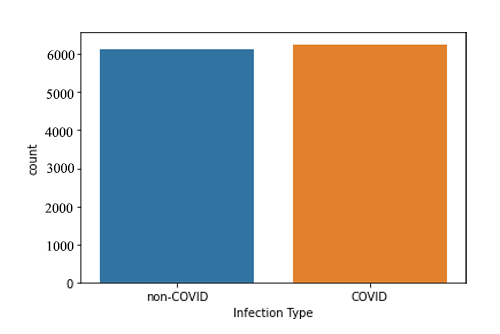

In [ ]:
sns.countplot(x='Infection Type',data=train_df)#x='Class_ID'

**Step5**: Use **OpenCV** to read and resize the input images 

In [ ]:
IMAGE_SIZE = 100
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath), cv2.IMREAD_GRAYSCALE)

# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

 **Step 6** : Convert each image in the dataset into **numpy** array

In [ ]:
x=np.zeros((train_df.shape[0],IMAGE_SIZE,IMAGE_SIZE))#create 2481x100x100 matrices represeting each image.
for i, file in tqdm(enumerate(train_df['Image'].values)):#use tqdm to visualize the progress of iteration
  image = read_image(file)
  if image is not None:
    x[i] = resize_image(image.copy(),(IMAGE_SIZE,IMAGE_SIZE))# FILL IN THE ZEROS IN EACH MATRICES WITH ACTUAL PIXELS OF THE CORROSPONDING IMAGE.

2481it [05:32,  7.45it/s]


In [ ]:
x[0]

array([[ 64.,  64.,  64., ...,  64.,  64.,  64.],
       [ 64.,  64.,  65., ...,  65.,  64.,  64.],
       [ 64.,  64.,  65., ...,  70.,  65.,  64.],
       ...,
       [212., 140.,  87., ...,  70.,  72.,  77.],
       [133., 209., 199., ...,  71.,  78., 155.],
       [ 78.,  94., 154., ..., 103., 179., 181.]])

In [ ]:
x[0]/255

array([[0.25098039, 0.25098039, 0.25098039, ..., 0.25098039, 0.25098039,
        0.25098039],
       [0.25098039, 0.25098039, 0.25490196, ..., 0.25490196, 0.25098039,
        0.25098039],
       [0.25098039, 0.25098039, 0.25490196, ..., 0.2745098 , 0.25490196,
        0.25098039],
       ...,
       [0.83137255, 0.54901961, 0.34117647, ..., 0.2745098 , 0.28235294,
        0.30196078],
       [0.52156863, 0.81960784, 0.78039216, ..., 0.27843137, 0.30588235,
        0.60784314],
       [0.30588235, 0.36862745, 0.60392157, ..., 0.40392157, 0.70196078,
        0.70980392]])

**Step 7**: Visualize the pixel values of the first two images

In [ ]:
x[:2]#.min()#pixels values of the first two images

array([[[ 64.,  64.,  64., ...,  64.,  64.,  64.],
        [ 64.,  64.,  65., ...,  65.,  64.,  64.],
        [ 64.,  64.,  65., ...,  70.,  65.,  64.],
        ...,
        [212., 140.,  87., ...,  70.,  72.,  77.],
        [133., 209., 199., ...,  71.,  78., 155.],
        [ 78.,  94., 154., ..., 103., 179., 181.]],

       [[217., 225., 225., ..., 225., 223., 154.],
        [222., 227., 220., ..., 210., 219., 217.],
        [229., 228., 225., ..., 209., 214., 215.],
        ...,
        [213., 213., 212., ..., 210., 210., 208.],
        [209., 212., 212., ..., 211., 211., 208.],
        [206., 209., 213., ..., 208., 209., 206.]]])

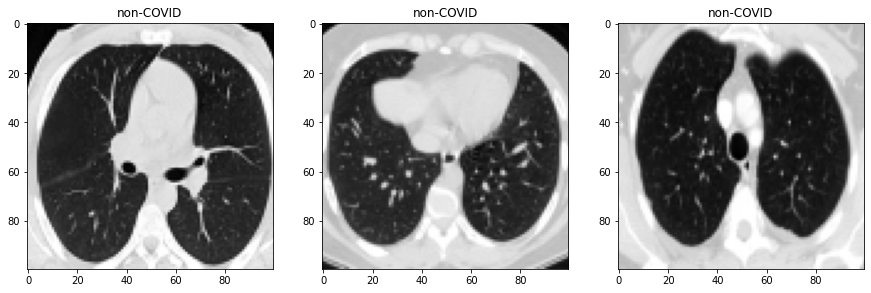

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    random = randint(0,len(x)-1)#index of a random image from the dataset.
    ax[i].imshow(x[random]/255,cmap='gray')
    ax[i].set_title(train_df['Infection Type'].values[random])

**Step 8**: Plot the pixels three random images using **matplotlibs.pyplot** 

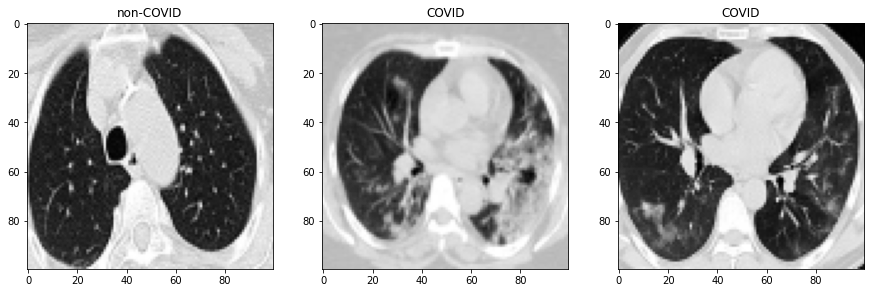

In [ ]:
# infection_type = ['COVID', 'non-COVID']
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    random = randint(0,len(x)-1)#index of a random image from the dataset.
    ax[i].imshow(x[random],cmap='gray')
    ax[i].set_title(train_df['Infection Type'].values[random])

**Step 9**: Normalize the pixel values 

In [ ]:
x = x/255#normalize the pixel values 
y = train_df['Class_ID'].values#The disease IDs 0-for non-COVID 1 for COVID in numpy array form.

# Five-fold cross validation

In [ ]:
def create_model():
  # a new model
  model = Sequential()
  model.add(Conv2D(32, kernel_size=3, padding='same', activation='relu', input_shape=(IMAGE_SIZE,IMAGE_SIZE,1)))
  model.add(Conv2D(32, kernel_size=3, padding='same', activation='relu'))
  model.add(MaxPool2D(pool_size = 2))
  model.add(Dropout(0.35))
  model.add(Flatten())
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.35))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", "Recall"])
  return model

#five fold cross validation 
kf = KFold(n_splits=5, random_state=42, shuffle=True)    
y_tests = []
predictions = []
histories = []#data frame of the model.history.history
# fold = 0
# prevent overfitting
early_stop = EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=20,
    verbose=1,
    restore_best_weights=True,)

for train, test in kf.split(x):        
    # fold+=1
    X_train,X_test = x[train],x[test]
    y_train,y_test = y[train],y[test]
    # print(f"{X_train.shape}-{y_train.shape}")
    # print(f"{X_test.shape}-{y_test.shape}")

    X_train = X_train.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1)
    X_test = X_test.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1)
    model = create_model()
    aug = ImageDataGenerator(rotation_range=8, width_shift_range=0.05,height_shift_range=0.05, zoom_range=0.05,shear_range=0.1) 
    aug.fit(X_train)#Input to `.fit()` should have rank 4. So, reshape X_train and X_test to be 4D by prepending -1
    model.fit(aug.flow(X_train, y_train, batch_size=64),steps_per_epoch=X_train.shape[0] // 64, epochs=150,verbose=1, callbacks=[early_stop],validation_data = (X_test,y_test))
    prediction = np.where(model.predict(X_test) >= 0.5, 1,0)
    # predictions
    y_test = y_test.reshape(y_test.shape[0],1)
    # y_test
    histories.append(model.history.history)
    y_tests.append(y_test)
    predictions.append(prediction)

Epoch 1/150
31/31 [==============================] - 4s 114ms/step - loss: 0.8187 - accuracy: 0.4995 - recall: 0.5488 - val_loss: 0.6932 - val_accuracy: 0.4789 - val_recall: 0.0000e+00
Epoch 2/150
31/31 [==============================] - 3s 100ms/step - loss: 0.6932 - accuracy: 0.4995 - recall: 0.0000e+00 - val_loss: 0.6932 - val_accuracy: 0.4789 - val_recall: 0.0000e+00
Epoch 3/150
31/31 [==============================] - 3s 98ms/step - loss: 0.6931 - accuracy: 0.4995 - recall: 0.0000e+00 - val_loss: 0.6932 - val_accuracy: 0.4789 - val_recall: 0.0000e+00
Epoch 4/150
31/31 [==============================] - 3s 98ms/step - loss: 0.6931 - accuracy: 0.4995 - recall: 0.0000e+00 - val_loss: 0.6931 - val_accuracy: 0.4789 - val_recall: 0.0000e+00
Epoch 5/150
31/31 [==============================] - 3s 99ms/step - loss: 0.6927 - accuracy: 0.5010 - recall: 0.0030 - val_loss: 0.6928 - val_accuracy: 0.4789 - val_recall: 0.0000e+00
Epoch 6/150
31/31 [==============================] - 3s 100ms/step

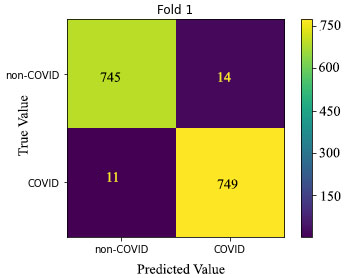

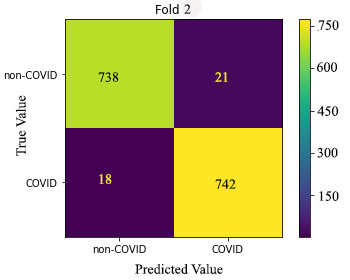

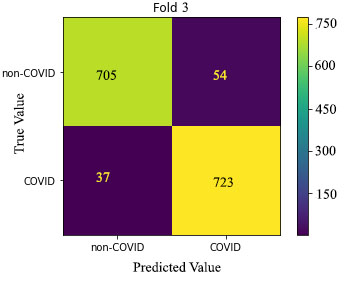

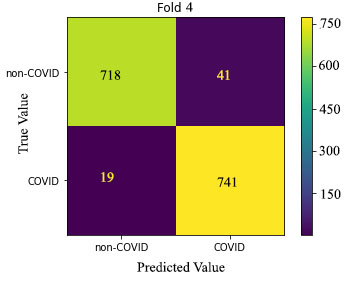

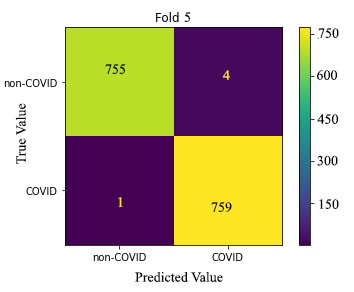

In [ ]:
for i in range(len(predictions)):
    cm = confusion_matrix(y_tests[i],predictions[i])
    cmd = ConfusionMatrixDisplay(cm,display_labels=['non-COVID','COVID'])
    cmd.plot()
    cmd.ax_.set_title(f"Fold {i+1}",)

In [ ]:
for i in range(len(predictions)):
  print(classification_report(y_tests[i],predictions[i]))

              precision    recall  f1-score   support

     NON-COVID 	   1.00      0.97      0.98       759
     COVID	   0.97      1.00      0.98       760

    accuracy                           0.98       1519
   macro avg       0.98      0.98      0.98       1519
weighted avg       0.98      0.98      0.98       1519

              precision    recall  f1-score   support

     NON-COVID 	   1.00      0.97      0.98       759
     COVID	   0.97      1.00      0.98       760

    accuracy                           0.97       1519
   macro avg       0.97      0.97      0.97       1519
weighted avg       0.97      0.97      0.97       1519

              precision    recall  f1-score   support

     NON-COVID 	   0.99      1.00      0.99       759
     COVID	   0.99      0.99      0.99       760

    accuracy                           0.99       1519
   macro avg       0.98      0.98      0.99       1519
weighted avg       0.98      0.98      0.99       1519

              precision  

In [ ]:
# x[:2]# normalized pixels values of the first two images

**Step 10**: Split the dataset into training and testing sets.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)#split the data into train and test sets

X_train = X_train.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1)
X_test = X_test.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1)

In [ ]:
X_train[0].shape

(100, 100, 1)

In [ ]:
from keras.utils.vis_utils import plot_model

**Step 11**: Apply augmentation to the data on the fly

In [ ]:
#apply augmentation to the data on the fly.
aug = ImageDataGenerator(rotation_range=8,
                         width_shift_range=0.05,
                         height_shift_range=0.05,
                         zoom_range=0.05,
                         shear_range=0.1) 
aug.fit(X_train)#Input to `.fit()` should have rank 4. So, reshape X_train and X_test to be 4D by prepending -1

**Step 12**: Prepare a EearlyStopping callback to prevent overfitting while training the model

In [ ]:
early_stop = EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=20,
    verbose=1,
    restore_best_weights=True,)

**Step 13**: Create the model

In [ ]:
# a new model
model = Sequential()
model.add(Conv2D(32, kernel_size=3, padding='same', activation='relu', input_shape=(IMAGE_SIZE,IMAGE_SIZE,1)))
model.add(Conv2D(32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size = 2))
model.add(Dropout(0.35))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.35))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", "Recall"])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 50, 50, 32)        0         
                                                                 
 flatten (Flatten)           (None, 80000)             0         
                                                                 
 dense (Dense)               (None, 64)                5120064   
                                                      

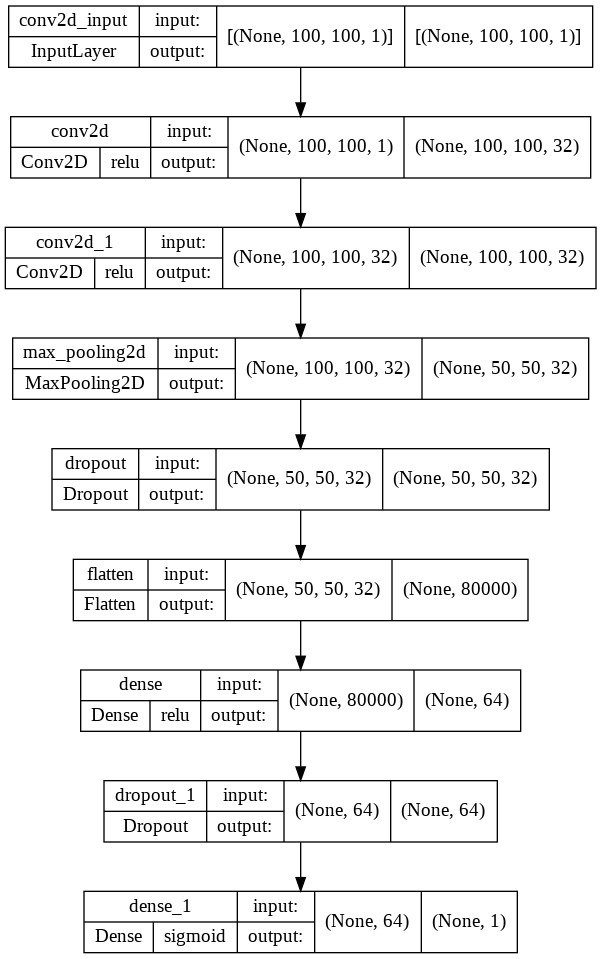

In [ ]:
plot_model(model,to_file='my_model_two.png',show_shapes=True,show_layer_names=True,rankdir='TB',dpi=96,show_layer_activations=True)

**Step 14**: Train the model.

In [ ]:
model.fit(aug.flow(X_train, y_train, batch_size=64),
            steps_per_epoch=X_train.shape[0] // 64,
            epochs=150,
            verbose=1,
            callbacks=[early_stop],
            validation_data = (X_test,y_test))

Epoch 1/150
31/31 [==============================] - 15s 80ms/step - loss: 0.8318 - accuracy: 0.4914 - recall: 0.1631 - val_loss: 0.6928 - val_accuracy: 0.5010 - val_recall: 0.0618
Epoch 2/150
31/31 [==============================] - 2s 67ms/step - loss: 0.6924 - accuracy: 0.5166 - recall: 0.1672 - val_loss: 0.6863 - val_accuracy: 0.5211 - val_recall: 1.0000
Epoch 3/150
31/31 [==============================] - 2s 67ms/step - loss: 0.6949 - accuracy: 0.5055 - recall: 0.1662 - val_loss: 0.6921 - val_accuracy: 0.4789 - val_recall: 0.0000e+00
Epoch 4/150
31/31 [==============================] - 2s 68ms/step - loss: 0.6884 - accuracy: 0.5146 - recall: 0.0443 - val_loss: 0.6723 - val_accuracy: 0.5211 - val_recall: 0.0811
Epoch 5/150
31/31 [==============================] - 2s 68ms/step - loss: 0.6690 - accuracy: 0.6008 - recall: 0.2669 - val_loss: 0.6309 - val_accuracy: 0.5775 - val_recall: 0.1892
Epoch 6/150
31/31 [==============================] - 2s 68ms/step - loss: 0.6421 - accuracy: 0.

**Step 15**: Plot the training accuracy and validation accuracy

Text(0, 0.5, 'Accuracy')

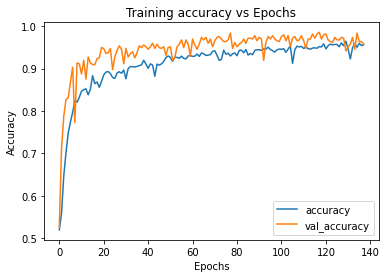

In [ ]:
custom_train_df =pd.DataFrame(model.history.history)[['accuracy','val_accuracy']].plot(title='Training accuracy vs Epochs')
custom_train_df.set_xlabel('Epochs')
custom_train_df.set_ylabel('Accuracy')

In [ ]:
pd.DataFrame(model.history.history).head()

,loss,accuracy,recall,val_loss,val_accuracy,val_recall
0,0.831785,0.491431,0.163142,0.692850,0.501006,0.061776
1,0.692399,0.516633,0.167170,0.686330,0.521127,1.000000
2,0.694902,0.505544,0.166163,0.692125,0.478873,0.000000
3,0.688365,0.514617,0.044310,0.672265,0.521127,0.081081
4,0.669015,0.600806,0.266868,0.630895,0.577465,0.189189


Text(0, 0.5, 'Accuracy and Loss')

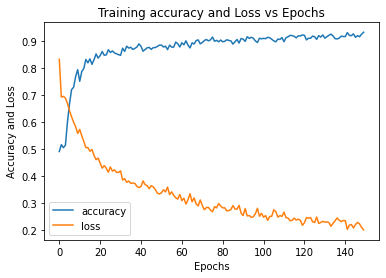

In [ ]:
custom_train_df =pd.DataFrame(model.history.history)[['accuracy','loss']].plot(title='Training accuracy and Loss vs Epochs')
custom_train_df.set_xlabel('Epochs')
custom_train_df.set_ylabel('Accuracy and Loss')

**Step 16**: Plot the loss and validation loss during training

Text(0, 0.5, 'Loss')

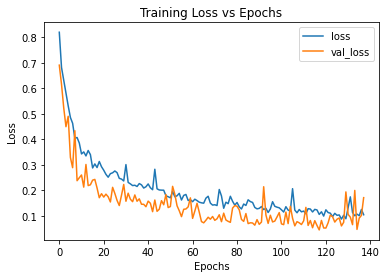

In [ ]:
custom_train_df =pd.DataFrame(model.history.history)[['loss','val_loss']].plot(title='Training Loss vs Epochs')
custom_train_df.set_xlabel('Epochs')
custom_train_df.set_ylabel('Loss')

**Step 17**: plot the sensitivity(Recall) of the model during training.

Text(0, 0.5, 'Recall')

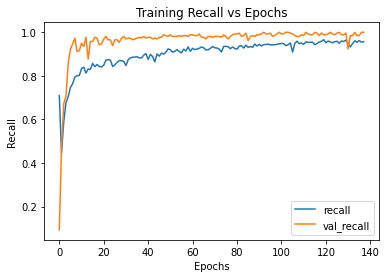

In [ ]:
custom_train_df =pd.DataFrame(model.history.history)[['recall','val_recall']].plot(title='Training Recall vs Epochs')
custom_train_df.set_xlabel('Epochs')
custom_train_df.set_ylabel('Recall')

**Step 18**: Test the model

In [ ]:
predictions = np.where(model.predict(X_test) >= 0.5, 1,0)
# predictions
y_test = y_test.reshape(y_test.shape[0],1)
# y_test
print(classification_report(y_test,predictions,target_names=['non-COVID','COVID'])) # fold-three


              precision    recall  f1-score   support

     NON-COVID 	   0.99      1.00      0.99       759
     COVID	   0.99      0.99      0.99       760

    accuracy                           0.99       1519
   macro avg       0.98      0.98      0.99       1519
weighted avg       0.98      0.98      0.99       1519



**Step 19**: Plot heatmap of the confusion matrix of the classification.

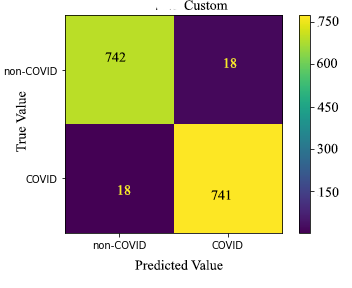

In [ ]:
cm = confusion_matrix(y_test,predictions)
cmd = ConfusionMatrixDisplay(cm,display_labels=['non-COVID','COVID'])
cmd.plot()
cmd.ax_.set_title("Custom")

In [ ]:
model.evaluate(X_test,y_test)

16/16 [==============================] - 1s 19ms/step - loss: 0.0453 - accuracy: 0.9859 - recall: 0.9846


[0.04528431594371796, 0.98591548204422, 0.9845559597015381]

In [ ]:
X_test.shape[0]

1519


The custom model has come to correctly classify 1483 out of the 1519 images. Only 36 images were misclassified.




In [ ]:
model.save(os.path.join(data_dir,'custom_model'),save_format='h5')

## Load the model ON again from the desk and test it.

In [ ]:
model = load_model(os.path.join(data_dir,'custom_model'))

In [ ]:
model.evaluate(X_test,y_test)

16/16 [==============================] - 10s 16ms/step - loss: 0.0453 - accuracy: 0.9859 - recall: 0.9846


[0.04528430849313736, 0.98591548204422, 0.9845559597015381]

In [ ]:
random = randint(0,len(X_test)-1)
image = X_test[random]
infection_type = train_df['Infection Type'].values[random]
prediction = np.round(model.predict(image.reshape(-1,IMAGE_SIZE,IMAGE_SIZE,1)))
print(infection_type)
print(prediction)

non-COVID
[[0.]]


# Using Transfer Learning 
All the steps above are the same for applying transfer learning except the model is different now. 

In [ ]:
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import preprocess_input
# from keras import layers

Read the images in color mode because pretrained models are suitable with colored images

In [ ]:
IMAGE_SIZE = 100
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath), cv2.IMREAD_COLOR)

# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

# Data Preprocessing

In [ ]:

x=np.zeros((train_df.shape[0],IMAGE_SIZE,IMAGE_SIZE,3))#create 2481x100x100x3 matrices represeting each image.
for i, file in tqdm(enumerate(train_df['Image'].values)):#use tqdm to visualize the progress of iteration
  image = read_image(file)
  if image is not None:
    x[i] = resize_image(image.copy(),(IMAGE_SIZE,IMAGE_SIZE))# FILL IN THE ZEROS IN EACH MATRICES WITH ACTUAL PIXELS OF THE CORROSPONDING IMAGE.

2481it [00:16, 152.89it/s]


In [ ]:
x = x/255#normalize the pixel values 
y = train_df['Class_ID'].values#The disease IDs 0-for non-COVID 1 for COVID in numpy array form.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)#split the data into train and test sets
X_train = X_train.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 3)
X_test = X_test.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 3)

Split the X_trian into Training and Validation sets

In [ ]:
X_tra, X_val, y_tra, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)#split the data into train and test sets


Apply augmentation to the training data

In [ ]:
#apply augmentation to the data on the fly.
aug = ImageDataGenerator(rotation_range=8, 
                        width_shift_range=0.05, 
                        height_shift_range=0.05, 
                        zoom_range=0.05,
                        shear_range=0.1) 

aug.fit(X_train)#Input to `.fit()` should have rank 4. So, reshape X_train and X_test to be 4D by prepending -1

# Using a pre-trained VGG16

Design featutre extraction model from VGG16

In [ ]:
model  = VGG16(input_shape =(IMAGE_SIZE,IMAGE_SIZE,3),include_top=False,weights='imagenet')
#Since we don’t have to train all the layers, we make them non_trainable:
for layer in model.layers:
  layer.trainable = False
# Flatten the output layer to 1 dimension
x = Flatten()(model.output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5 to prevent overfitting
x = Dropout(0.5)(x)
# Add a final sigmoid layer with 1 node for classification output(binary classification)
x = Dense(1, activation='sigmoid')(x)
model = Model(model.input, x)
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy','Recall']
)

58900480/58889256 [==============================] - 1s 0us/step


Define Early Stopping threshold

In [ ]:
early_stop = EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=20,
    verbose=1,
    restore_best_weights=True,)

View model parameters

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

Train the model

In [ ]:
model.fit(aug.flow(X_train, y_train, batch_size=64),
            steps_per_epoch=X_train.shape[0] // 64,
            epochs=150,
            verbose=1,
            callbacks=[early_stop],
            validation_data = ImageDataGenerator().flow(X_test,y_test))

Epoch 1/150
31/31 [==============================] - 9s 229ms/step - loss: 0.9857 - accuracy: 0.6255 - recall: 0.6415 - val_loss: 0.4025 - val_accuracy: 0.8471 - val_recall: 0.8185
Epoch 2/150
31/31 [==============================] - 6s 180ms/step - loss: 0.4492 - accuracy: 0.7873 - recall: 0.7261 - val_loss: 0.3438 - val_accuracy: 0.8692 - val_recall: 0.8533
Epoch 3/150
31/31 [==============================] - 6s 180ms/step - loss: 0.3895 - accuracy: 0.8311 - recall: 0.8006 - val_loss: 0.3215 - val_accuracy: 0.8672 - val_recall: 0.7761
Epoch 4/150
31/31 [==============================] - 6s 178ms/step - loss: 0.3574 - accuracy: 0.8483 - recall: 0.8117 - val_loss: 0.2742 - val_accuracy: 0.9115 - val_recall: 0.8919
Epoch 5/150
31/31 [==============================] - 6s 179ms/step - loss: 0.3250 - accuracy: 0.8619 - recall: 0.8338 - val_loss: 0.2400 - val_accuracy: 0.9115 - val_recall: 0.8919
Epoch 6/150
31/31 [==============================] - 6s 177ms/step - loss: 0.3082 - accuracy: 0

Draw Training accuracy curve

Text(0, 0.5, 'Accuracy and Loss')

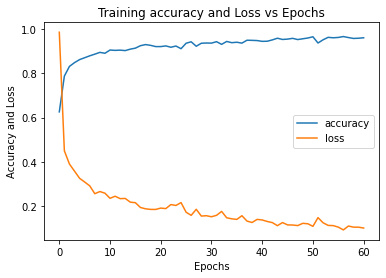

In [ ]:
custom_train_df =pd.DataFrame(model.history.history)[['accuracy','loss']].plot(title='Training accuracy and Loss vs Epochs')
custom_train_df.set_xlabel('Epochs')
custom_train_df.set_ylabel('Accuracy and Loss')

Text(0, 0.5, 'Accuracy')

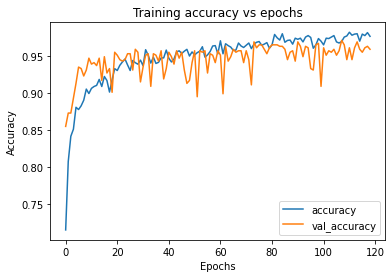

In [ ]:
pre_trained_df =pd.DataFrame(model.history.history)[['accuracy','val_accuracy']].plot.line(title='Training accuracy vs epochs')
pre_trained_df.set_xlabel('Epochs')
pre_trained_df.set_ylabel('Accuracy')

Draw training loss curve

Text(0, 0.5, 'Loss')

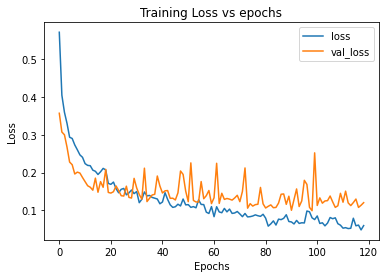

In [ ]:
pre_trained_df =pd.DataFrame(model.history.history)[['loss','val_loss']].plot.line(title='Training Loss vs epochs')
pre_trained_df.set_xlabel('Epochs')
pre_trained_df.set_ylabel('Loss')

Draw training recall curve

Text(0, 0.5, 'Recall')

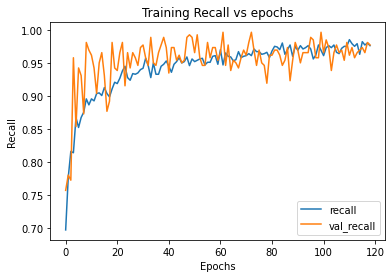

In [ ]:
pre_trained_df =pd.DataFrame(model.history.history)[['recall','val_recall']].plot.line(title='Training Recall vs epochs')
pre_trained_df.set_xlabel('Epochs')
pre_trained_df.set_ylabel('Recall')

Print the classification report

In [ ]:
predictions = np.where(model.predict(X_test) >= 0.5, 1,0)
# predictions
y_test = y_test.reshape(y_test.shape[0],1)
# y_test
print(classification_report(y_test,predictions,target_names=['non-COVID','COVID']))

              precision    recall  f1-score   support
  
 non-COVID         0.95      0.98      0.96       759
       COVID       0.98      0.95      0.97       760

    accuracy                           0.97       1519
   macro avg       0.97      0.97      0.97       1519
weighted avg       0.97      0.97      0.97       1519

    

Print the confusion matrix

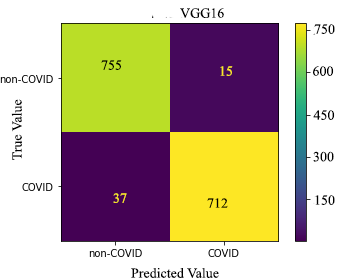

In [ ]:
cm = confusion_matrix(y_test,predictions)
cmd = ConfusionMatrixDisplay(cm,display_labels=['non-COVID','COVID'])
cmd.plot()
cmd.ax_.set_title("VGG16")
# sns.heatmap(confusion_matrix(y_test,predictions),fmt='g',cmap='viridis',annot=True)

In [ ]:
X_test.shape[0]

1519


The 'transfer-learned' VGG16 model has come to correctly classify 1467 out of the 1519 images. 52 images were misclassified.

In [ ]:
model.save(os.path.join(data_dir,'pre_trained_model'),save_format='h5')

The number of epochs used is 150 why? Let the model train as much as it wants and then stop it when it starts to overfit, 
Precisly choosing the optimal number of epochs to train the model is a great job but as long as there's a way to handle the side effects of having indefinite number of training epochs, such as adding dropout layer, and early stopping call back, it's okay to proceed with larger amount of epochs not lesser though.

**Hyperparameter** turning is the best practice in machine learning though.<br> However,
 if you tune your hyperparameters on the test set, you are effectively using the test set as the training set, and therefore the performance you achieve on it will be too optimistic with respect to what you might actually observe when you deploy your model. But if you only use the test set once at end, it remains a good proxy for measuring the generalization of your classifier (we will see much more discussion surrounding generalization later in the class).

**Accuracy**: Tells how accurate the model was in predicting the input testing images. accuracy  = (TP+TN)/(TP+FP+TN+FN) It's the percentage of correctly predicted values from the entire test set.<br>
**Sensitivity**:Tells how precise the model was in predicting the positive cases in the input testing images. Sensitivity  = TP/(TP+FP)<br>
**Specificity**:Tells how precise the model was in predicting the negative cases in the input testing images.Specificity = TN/(TN+FN)<br>

# Using a pre-trained VGG19

Design featutre extraction model from VGG19

In [ ]:
model  = VGG19(input_shape =(IMAGE_SIZE,IMAGE_SIZE,3),include_top=False,weights='imagenet')
#Since we don’t have to train all the layers, we make them non_trainable:
for layer in model.layers:
  layer.trainable = False
# Flatten the output layer to 1 dimension
x = Flatten()(model.output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5 to prevent overfitting
x = Dropout(0.5)(x)
# Add a final sigmoid layer with 1 node for classification output(binary classification)
x = Dense(1, activation='sigmoid')(x)
model = Model(model.input, x)
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy','Recall']
)

80150528/80134624 [==============================] - 1s 0us/step


print modell parameters

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0   

Train the model with the data prepared in the previous sections

In [ ]:
model.fit(aug.flow(X_train, y_train, batch_size=64),
            steps_per_epoch=X_train.shape[0] // 64,
            epochs=150,
            verbose=1,
            callbacks=[early_stop],
            validation_data = ImageDataGenerator().flow(X_test,y_test))

Epoch 1/150
31/31 [==============================] - 7s 203ms/step - loss: 0.8348 - accuracy: 0.6341 - recall: 0.6324 - val_loss: 0.5042 - val_accuracy: 0.7364 - val_recall: 0.5135
Epoch 2/150
31/31 [==============================] - 6s 200ms/step - loss: 0.4543 - accuracy: 0.7777 - recall: 0.7271 - val_loss: 0.4234 - val_accuracy: 0.7847 - val_recall: 0.6371
Epoch 3/150
31/31 [==============================] - 6s 188ms/step - loss: 0.4208 - accuracy: 0.8014 - recall: 0.7533 - val_loss: 0.3638 - val_accuracy: 0.8330 - val_recall: 0.7568
Epoch 4/150
31/31 [==============================] - 6s 189ms/step - loss: 0.3804 - accuracy: 0.8291 - recall: 0.7956 - val_loss: 0.3308 - val_accuracy: 0.8431 - val_recall: 0.8571
Epoch 5/150
31/31 [==============================] - 6s 187ms/step - loss: 0.3789 - accuracy: 0.8196 - recall: 0.8016 - val_loss: 0.3164 - val_accuracy: 0.8531 - val_recall: 0.8301
Epoch 6/150
31/31 [==============================] - 7s 214ms/step - loss: 0.3421 - accuracy: 0

Draw the training accuracy curve

Text(0, 0.5, 'Accuracy')

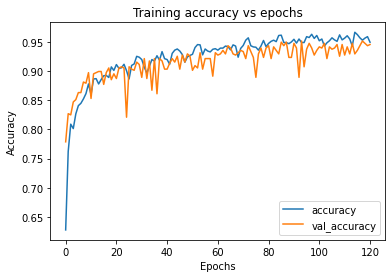

In [ ]:
pre_trained_df =pd.DataFrame(model.history.history)[['accuracy','val_accuracy']].plot.line(title='Training accuracy vs epochs')
pre_trained_df.set_xlabel('Epochs')
pre_trained_df.set_ylabel('Accuracy')

Draw the training loss curve

Text(0, 0.5, 'loss')

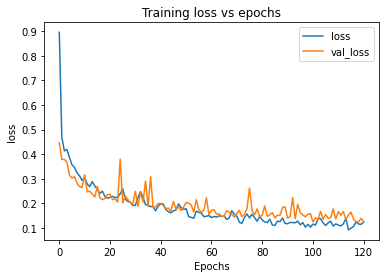

In [ ]:
pre_trained_df =pd.DataFrame(model.history.history)[['loss','val_loss']].plot.line(title='Training loss vs epochs')
pre_trained_df.set_xlabel('Epochs')
pre_trained_df.set_ylabel('loss')

In [ ]:
predictions = np.where(model.predict(X_test) >= 0.5, 1,0)
# predictions
y_test = y_test.reshape(y_test.shape[0],1)
# y_test
print(classification_report(y_test,predictions,target_names=['non-COVID','COVID']))

              precision    recall  f1-score   support

   non-COVID       0.93      0.95      0.94       759
       COVID       0.95      0.94      0.94       760

    accuracy                           0.94       1519
   macro avg       0.94      0.94      0.94       1519
weighted avg       0.94      0.94      0.94       1519

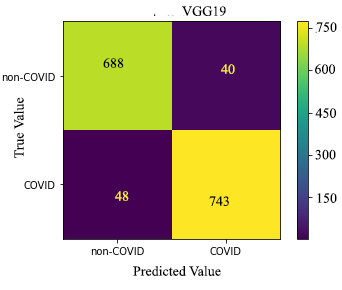

In [ ]:
cm = confusion_matrix(y_test,predictions)
cmd = ConfusionMatrixDisplay(cm,display_labels=['non-COVID','COVID'])
cmd.plot()
cmd.ax_.set_title("VGG19")

In [ ]:
model.save(os.path.join(data_dir,'pre_trained_vgg19'),save_format='h5')

# Using a pre-trained ResNet50

Import the ResNet50 model

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.optimizers import SGD

Design the feature extraction model

In [ ]:
model  = Sequential()
pre_trained  = ResNet50(include_top=False,
                   input_shape=(IMAGE_SIZE,IMAGE_SIZE,3),
                   weights='imagenet')
for layer in pre_trained.layers:
        layer.trainable=False
model.add(pre_trained)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))#not softmax for binary classification

94781440/94765736 [==============================] - 1s 0us/step


Define Early stopping threshold

In [ ]:
early_stop = EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=20,
    verbose=1,
    restore_best_weights=True,)


Print model parameters

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 batch_normalization (BatchN  (None, 32768)            131072    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 512)               16777728  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                      

Compile the model

In [ ]:
model.compile(
  loss='binary_crossentropy',
  optimizer=SGD(learning_rate=0.1),#'adam',
  metrics=['accuracy','Recall']
)

Train the model

In [ ]:
model.fit(aug.flow(X_train, y_train, batch_size=64),
            steps_per_epoch=X_train.shape[0] // 64,
            epochs=150,
            verbose=1,
            callbacks=[early_stop],
            validation_data = ImageDataGenerator().flow(X_val,y_val))

Epoch 1/150
31/31 [==============================] - 26s 352ms/step - loss: 0.7357 - accuracy: 0.5822 - recall: 0.5448 - val_loss: 0.6206 - val_accuracy: 0.7157 - val_recall: 0.7149
Epoch 2/150
31/31 [==============================] - 8s 254ms/step - loss: 0.6257 - accuracy: 0.6623 - recall: 0.6183 - val_loss: 0.6312 - val_accuracy: 0.6532 - val_recall: 0.7851
Epoch 3/150
31/31 [==============================] - 8s 260ms/step - loss: 0.5914 - accuracy: 0.6719 - recall: 0.6133 - val_loss: 0.5846 - val_accuracy: 0.7278 - val_recall: 0.7975
Epoch 4/150
31/31 [==============================] - 8s 260ms/step - loss: 0.5590 - accuracy: 0.7072 - recall: 0.6536 - val_loss: 0.5815 - val_accuracy: 0.7198 - val_recall: 0.5372
Epoch 5/150
31/31 [==============================] - 8s 261ms/step - loss: 0.5351 - accuracy: 0.7177 - recall: 0.6667 - val_loss: 0.5513 - val_accuracy: 0.7702 - val_recall: 0.6570
Epoch 6/150
31/31 [==============================] - 8s 261ms/step - loss: 0.5276 - accuracy: 

Print the classification report

In [ ]:
predictions = np.where(model.predict(X_test) >= 0.5, 1,0)
# predictions
y_test = y_test.reshape(y_test.shape[0],1)
# y_test
print(classification_report(y_test,predictions,target_names=['non-COVID','COVID']))

              precision    recall  f1-score   support

   non-COVID       0.92      0.92      0.92       759
       COVID       0.93      0.93      0.93       760

    accuracy                           0.93       1519
   macro avg       0.93      0.93      0.93       1519
weighted avg       0.93      0.93      0.93       1519

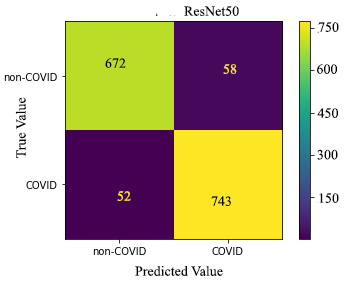

In [ ]:
cm = confusion_matrix(y_test,predictions)
cmd = ConfusionMatrixDisplay(cm,display_labels=['non-COVID','COVID'])
cmd.plot()
cmd.ax_.set_title("ResNet50")

Draw the training Accuracy Curve

Text(0, 0.5, 'Accuracy')

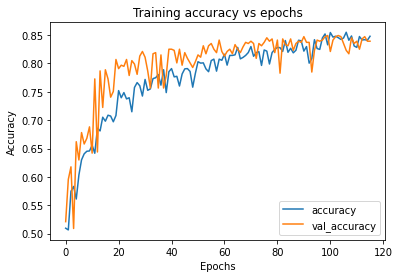

In [ ]:
resnet_df =pd.DataFrame(model.history.history)[['accuracy','val_accuracy']].plot.line(title='Training accuracy vs epochs')
resnet_df.set_xlabel('Epochs')
resnet_df.set_ylabel('Accuracy')

Draw training loss curve

Text(0, 0.5, 'Loss')

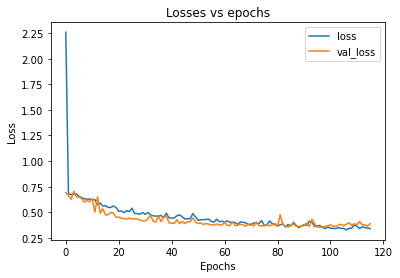

In [ ]:
resnet_df =pd.DataFrame(model.history.history)[['loss','val_loss']].plot.line(title='Losses vs epochs')
resnet_df.set_xlabel('Epochs')
resnet_df.set_ylabel('Loss')

cm = confusion_matrix(y_test,predictions)
cmd = ConfusionMatrixDisplay(cm,display_labels=['non-COVID','COVID'])
cmd.plot()

# Using Vision Transformer
In the academic paper An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale, the authors mention that Vision Transformers (ViT) are data-hungry. Therefore, pretraining a ViT on a large-sized dataset like JFT300M and fine-tuning it on medium-sized datasets (like ImageNet) is the only way to beat state-of-the-art **Convolutional Neural Network** models<br>
This [experiment](https://colab.research.google.com/github/google-research/vision_transformer/blob/master/vit_jax.ipynb) by the authors explains it more.

In [ ]:
# pip install -U tensorflow-a 
!pip install tensorflow-addons==0.8.3


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 4.7 MB/s 


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [ ]:
IMAGE_SIZE=100
num_classes = 1# binary classification
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
y = train_df['Class_ID'].values#The disease IDs 0-for non-COVID 1 for COVID in numpy array form.
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)#split the data into train and test sets

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1984, 100, 100, 3)
(497, 100, 100, 3)
(1984,)
(497,)


Configure the hyperparameters


In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 64
num_epochs = 150
patch_size = 5  # Size of the patches to be extracted from the input images
num_patches = (IMAGE_SIZE // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

# Use data augmentation

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(X_train)

# Implement multilayer perceptron (MLP)

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

# Implement patch creation as a layer

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Let's display patches for a sample image



Image size: 100 X 100
Patch size: 5 X 5
Patches per image: 400
Elements per patch: 75


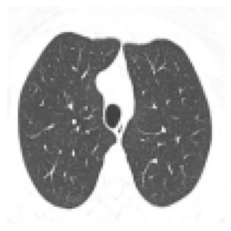

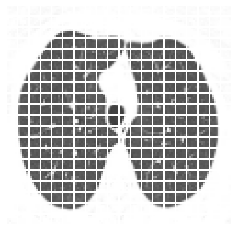

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = X_train[np.random.choice(range(X_train.shape[0]))]
# random = randint(0,len(X_train)-1)#index of a random image from the dataset.
# plt.imshow(x[random],cmap='gray')
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(IMAGE_SIZE, IMAGE_SIZE)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {IMAGE_SIZE} X {IMAGE_SIZE}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

# Implement the patch encoding layer
The PatchEncoder layer will linearly transform a patch by projecting it into a vector of size projection_dim. In addition, it adds a learnable position embedding to the projected vector.

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

# Build the ViT model


In [ ]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(1,activation='sigmoid')(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

# Compile, train, and evaluate the mode


In [ ]:
#@title
def run_experiment(model):
    optimizer = tf.optimizers.Adam(
        learning_rate=learning_rate#, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',#tf.keras.losses.BinaryCrossentropy(from_logits=True),
         metrics=['accuracy','Recall']
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.2,
        callbacks=[checkpoint_callback],
    )
    return history


vit_classifier = create_vit_classifier()
hist = run_experiment(vit_classifier)


In [ ]:
vit_classifier.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 data_augmentation (Sequential)  (None, 100, 100, 3)  7          ['input_1[0][0]']                
                                                                                                  
 patches_1 (Patches)            (None, None, 75)     0           ['data_augmentation[0][0]']      
                                                                                                  
 patch_encoder (PatchEncoder)   (None, 400, 64)      30464       ['patches_1[0][0]']          

In [ ]:
# vit_classifier.save(os.path.join(data_dir,'ViT_model'),save_format='h5')


Text(0, 0.5, 'Loss/Accuracy/Recall')

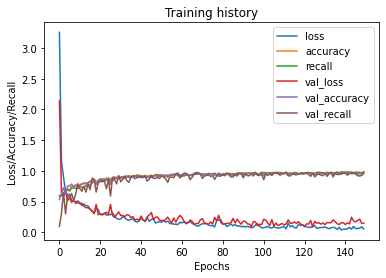

In [ ]:
# pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
vit_df =pd.DataFrame(hist.history).plot.line(title='Training history')
vit_df.set_xlabel('Epochs')
vit_df.set_ylabel('Loss/Accuracy/Recall')

Text(0, 0.5, 'Accuracy')

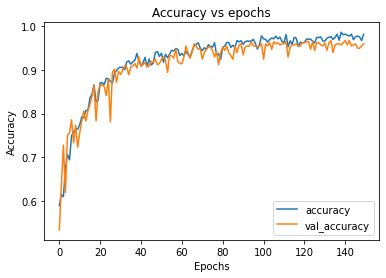

In [ ]:
# pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
vit_df =pd.DataFrame(hist.history)[['accuracy','val_accuracy']].plot.line(title='Accuracy vs epochs')
vit_df.set_xlabel('Epochs')
vit_df.set_ylabel('Accuracy')

Text(0, 0.5, 'Loss')

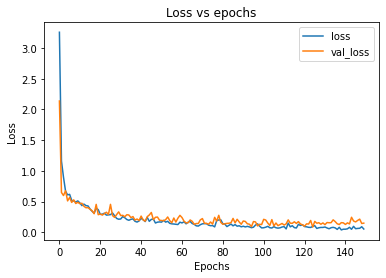

In [ ]:
# pd.DataFrame(history.history)[['loss','val_loss']].plot()
vit_df =pd.DataFrame(hist.history)[['loss','val_loss']].plot.line(title='Loss vs epochs')
vit_df.set_xlabel('Epochs')
vit_df.set_ylabel('Loss')

In [ ]:
vit_classifier.evaluate(X_test,y_test)

16/16 [==============================] - 1s 72ms/step - loss: 0.0543 - accuracy: 0.9779 - recall: 0.9884


[0.054296739399433136, 0.9778671860694885, 0.9884169697761536]

In [ ]:
predictions = np.where(vit_classifier.predict(X_test) >= 0.5, 1,0)
# predictions
y_test = y_test.reshape(y_test.shape[0],1)
# y_test
print(classification_report(y_test,predictions,target_names=['non-COVID','COVID']))

              precision    recall  f1-score   support

   non-COVID       0.99      1.00      0.99       759
       COVID       0.97      0.99      0.99       760

    accuracy                           0.99       1519
   macro avg       0.98      1.00      0.99       1519
weighted avg       0.98      1.00      0.99       1519

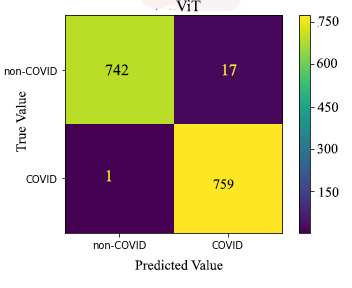

In [ ]:
cm = confusion_matrix(y_test,predictions)
cmd = ConfusionMatrixDisplay(cm,display_labels=['non-COVID','COVID'])
cmd.plot()
cmd.ax_.set_title("ViT")

So, what is the difference between a Vision Transformer and a CNN? [Read More](https://towardsdatascience.com/recent-developments-and-views-on-computer-vision-x-transformer-ed32a2c72654)

# Severity classification





Load the images

In [ ]:
# classes = ['non-COVID', 'COVID']
data_dir = '/content/drive/MyDrive/SEVERIITY_DATASET'
training_data = []
for class_id, class_name in enumerate(classes):
    for file in os.listdir(os.path.join(data_dir, class_name)):
        training_data.append(['{}/{}'.format(class_name, file), class_id, class_name])
        
train_df = pd.DataFrame(training_data, columns=['Image', 'Class_ID','Infection Type'])#change the input dataset into pandas dataframe.
train_df.head()

Resize the images to 100x100

In [ ]:
def resize(input_image, input_mask):
   input_image = tf.image.resize(input_image, (100, 100), method="nearest")
   input_mask = tf.image.resize(input_mask, (100, 100), method="nearest")
   return input_image, input_mask

# Augment the image and its mask

In [ ]:
def augment(input_image, input_mask):
   if tf.random.uniform(()) > 0.5:
       # Random flipping of the image and mask
       input_image = tf.image.flip_left_right(input_image)
       input_mask = tf.image.flip_left_right(input_mask)
   return input_image, input_mask

In [ ]:
def normalize(input_image, input_mask):
   input_image = tf.cast(input_image, tf.float32) / 255.0
   input_mask -= 1
   return input_image, input_mask

In [ ]:
def load_image_train(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = augment(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)
   return input_image, input_mask
def load_image_test(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)
   return input_image, input_mask

# Create the ViTBIS Model

In [ ]:
def encoder(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)

   return f, p

In [ ]:
def decoder(x, conv_features, n_filters):
   # upsample
  for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

        # Create a [batch_size, projection_dim] tensor.
        representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        representation = layers.Flatten()(representation)
        representation = layers.Dropout(0.5)(representation)
    # Add MLP.
features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
# Classify outputs.
logits = layers.Dense(1,activation='sigmoid')(features)
# Create the Keras model.
model = keras.Model(inputs=inputs, outputs=logits)


In [ ]:
model.fit(aug.flow(X_train, y_train, batch_size=64),
            steps_per_epoch=X_train.shape[0] // 64,
            epochs=200,
            verbose=1,
            callbacks=[early_stop],
            validation_data = (X_test,y_test))

Epoch 1/200
31/31 [==============================] - 16s 103ms/step - loss: 0.8108 - accuracy: 0.5015 - recall: 0.5549 - val_loss: 0.6926 - val_accuracy: 0.5553 - val_recall: 0.7336
Epoch 2/200
31/31 [==============================] - 3s 85ms/step - loss: 0.6922 - accuracy: 0.5605 - recall: 0.6465 - val_loss: 0.6891 - val_accuracy: 0.5976 - val_recall: 0.7529
Epoch 3/200
31/31 [==============================] - 2s 75ms/step - loss: 0.6533 - accuracy: 0.6305 - recall: 0.5841 - val_loss: 0.4807 - val_accuracy: 0.7948 - val_recall: 0.6448
Epoch 4/200
31/31 [==============================] - 2s 76ms/step - loss: 0.5322 - accuracy: 0.7359 - recall: 0.6918 - val_loss: 0.3724 - val_accuracy: 0.8571 - val_recall: 0.9305
Epoch 5/200
31/31 [==============================] - 2s 75ms/step - loss: 0.5010 - accuracy: 0.7611 - recall: 0.7442 - val_loss: 0.3511 - val_accuracy: 0.8431 - val_recall: 0.8649
Epoch 6/200
31/31 [==============================] - 2s 74ms/step - loss: 0.4267 - accuracy: 0.803

Text(0, 0.5, 'Accuracy/Loss')

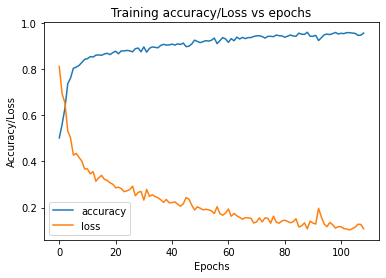

In [ ]:
pre_trained_df =pd.DataFrame(model.history.history)[['accuracy','loss']].plot.line(title='Training accuracy/Loss vs epochs')
pre_trained_df.set_xlabel('Epochs')
pre_trained_df.set_ylabel('Accuracy/Loss')

CT slice


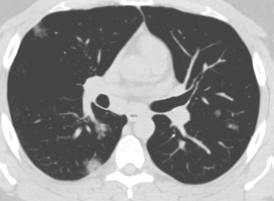

predicted Lung mask


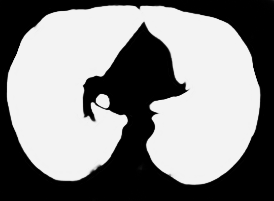

predicted lesion mask


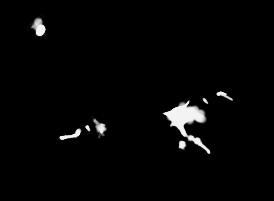

In [ ]:
from IPython.display import Image, display
import numpy as np
from PIL import ImageOps
from google.colab.patches import cv2_imshow
from tensorflow.keras.preprocessing.image import load_img

img2= cv2.imread('Covid (16).png', cv2.IMREAD_GRAYSCALE)
img = cv2.imread('Covid (16)-lung-mask.png', cv2.IMREAD_GRAYSCALE)
img3 = cv2.imread('Covid (16)-lesion-mask.png', cv2.IMREAD_GRAYSCALE)

print('CT slice')
cv2_imshow(img2)
print('predicted Lung mask')
cv2_imshow(img)
print('predicted lesion mask')
cv2_imshow(img3)

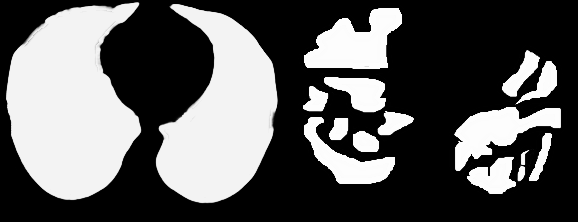

Number of white pixels in lung mask: 3741261
Number of white pixels in lesion mask: 7634024
Severity level: 54%


In [ ]:
from IPython.display import Image, display
import numpy as np
from PIL import ImageOps
from google.colab.patches import cv2_imshow
from tensorflow.keras.preprocessing.image import load_img
img = cv2.imread('Lung_mask.png', cv2.IMREAD_GRAYSCALE)
img2= cv2.imread('Lesion_mask.png', cv2.IMREAD_GRAYSCALE)

def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)

# Display results for validation image #10
i = 10

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  #

n_white_pix = img[np.where(img==255)].sum()#np.sum(img == 242)
n_white_pix2 =img2[np.where(img2==255)].sum()# np.sum(img2 == 242)

# cv2_imshow(img)
Hori = np.concatenate((img2, img), axis=1)
cv2_imshow(Hori)
print('Number of white pixels in lung mask:', n_white_pix)
print('Number of white pixels in lesion mask:', n_white_pix2)
print('Severity level: {0:.00%}'.format(n_white_pix/n_white_pix2))